<a href="https://colab.research.google.com/github/Sgraham6/Sean-Graham-Projects/blob/main/Laptop_Regression_Cleaning/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as oi

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Laptop_Data = pd.read_csv('/content/drive/MyDrive/Personal Files/Regression Practice/laptopData.csv')
Laptop_Data.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [ ]:
def show_values():
  for column in Laptop_Data.columns:
    if Laptop_Data[column].dtype == 'object':
      print(Laptop_Data[column].value_counts())
      print('')

In [ ]:
#show_values()

In [ ]:
# Cleaning

Laptop_Data = Laptop_Data.replace('?', np.nan).dropna().reset_index().drop(['Unnamed: 0', 'index'], axis=1)

In [ ]:
# Break up columns and change types

# RAM
Laptop_Data = Laptop_Data.rename(columns={'Ram': 'Ram (GB)'})
Laptop_Data['Ram (GB)'] = Laptop_Data['Ram (GB)'].str.replace('GB', '').astype(int)

# Weight
Laptop_Data = Laptop_Data.rename(columns={'Weight': 'Weight (kg)'})
Laptop_Data['Weight (kg)'] = Laptop_Data['Weight (kg)'].str.replace('kg', '').astype(float)

# Inches
Laptop_Data['Inches'] = Laptop_Data['Inches'].astype(float)

# CPU
Laptop_Data = Laptop_Data.rename(columns={'Cpu': 'CpuType'})
Laptop_Data['Cpu (GHz)'] = 'None'

for i in Laptop_Data.index:
  Laptop_Data.loc[i, ['CpuType','Cpu (GHz)']] = Laptop_Data.loc[i, 'CpuType'].rsplit(' ', 1)

Laptop_Data['Cpu (GHz)'] = Laptop_Data['Cpu (GHz)'].str.replace('GHz', '').astype(float)

# Memory
Laptop_Data = Laptop_Data.rename(columns={'Memory': 'MemoryGB1'})
Laptop_Data[['MemoryType1', 'MemoryType2']] = 'None'
Laptop_Data[['MemoryGB2']] = '0'

for i in Laptop_Data.index:
  if ' +  ' in Laptop_Data['MemoryGB1'][i]:
    Laptop_Data.loc[i, ['MemoryGB1','MemoryGB2']] = Laptop_Data.loc[i, 'MemoryGB1'].split(' +  ')
    Laptop_Data.loc[i, ['MemoryGB2', 'MemoryType2']] = Laptop_Data.loc[i, 'MemoryGB2'].split(' ', 1)
  Laptop_Data.loc[i, ['MemoryGB1', 'MemoryType1']] = Laptop_Data.loc[i, 'MemoryGB1'].split(' ', 1)

Laptop_Data['MemoryGB1'] = Laptop_Data['MemoryGB1'].str.replace('GB', '').str.replace('.0', '').str.replace('TB', '000')
Laptop_Data['MemoryGB2'] = Laptop_Data['MemoryGB2'].str.replace('GB', '').str.replace('.0', '').str.replace('TB', '000')

# Screen
Laptop_Data['ScreenDisplayType'] = 'None'
Laptop_Data[['ScreenIPSPanel', 'ScreenTouchscreen']] = 'No'

for i in Laptop_Data.index:
  if ' ' in Laptop_Data['ScreenResolution'][i]:
    Laptop_Data.loc[i, ['ScreenDisplayType', 'ScreenResolution']] = Laptop_Data.loc[i, 'ScreenResolution'].rsplit(' ', 1)
  if 'IPS Panel' in Laptop_Data['ScreenDisplayType'][i]:
    Laptop_Data.loc[i, ['ScreenIPSPanel']] = 'Yes'
    Laptop_Data.loc[i, ['ScreenDisplayType']] = Laptop_Data.loc[i, 'ScreenDisplayType'].replace('IPS Panel', '').replace('/', '').strip()
  if 'Touchscreen' in Laptop_Data['ScreenDisplayType'][i]:
    Laptop_Data.loc[i, ['ScreenTouchscreen']] = 'Yes'
    Laptop_Data.loc[i, ['ScreenDisplayType']] = Laptop_Data.loc[i, 'ScreenDisplayType'].replace('Touchscreen', '').replace('/', '').strip()
  if Laptop_Data['ScreenDisplayType'][i] == '':
    Laptop_Data.loc[i, ['ScreenDisplayType']] = 'None'

In [ ]:
#show_values()

In [ ]:
# Group Cpu columns
# Gotten from the datascience+ website

Laptop_Data_sub = Laptop_Data[['CpuType', 'Cpu (GHz)', 'Ram (GB)']]
cluster = Laptop_Data_sub.groupby('CpuType').mean()[['Cpu (GHz)', 'Ram (GB)']]
cluster.describe()

,Cpu (GHz),Ram (GB)
count,93.000000,93.000000
mean,2.080058,8.035138
std,0.652330,5.603152
min,0.900000,2.000000
25%,1.500000,4.000000
50%,2.200000,7.000000
75%,2.600000,8.606061
max,3.342857,32.000000


In [ ]:
cluster1 = cluster[(cluster['Cpu (GHz)'] < 2.2) & (cluster['Ram (GB)'] < 7)]
cluster2 = cluster[(cluster['Cpu (GHz)'] < 2.2) & (cluster['Ram (GB)'] >= 7)]
cluster3 = cluster[(cluster['Cpu (GHz)'] >= 2.2) & (cluster['Ram (GB)'] < 7)]
cluster4 = cluster[(cluster['Cpu (GHz)'] >= 2.2) & (cluster['Ram (GB)'] >= 7)]

def cpu_group(x):
  if x in cluster1.index:
    return 'Low GHz, Low Ram'
  elif x in cluster2.index:
    return 'Low GHz, High Ram'
  elif x in cluster3.index:
    return 'High GHz, Low Ram'
  else:
    return 'High GHz, High Ram'

Laptop_Data['CpuType'] = Laptop_Data.CpuType.apply(cpu_group)
Laptop_Data = Laptop_Data.drop(['Cpu (GHz)', 'Ram (GB)'], axis=1)

In [ ]:
#show_values()

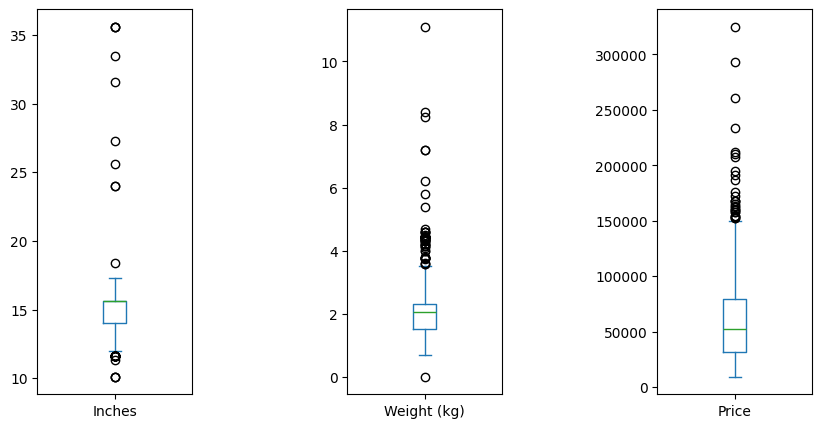

In [ ]:
# Outlier Checking

Laptop_Data.plot(kind='box', subplots=True, figsize=(10, 5))
plt.subplots_adjust(wspace=1)
plt.show()

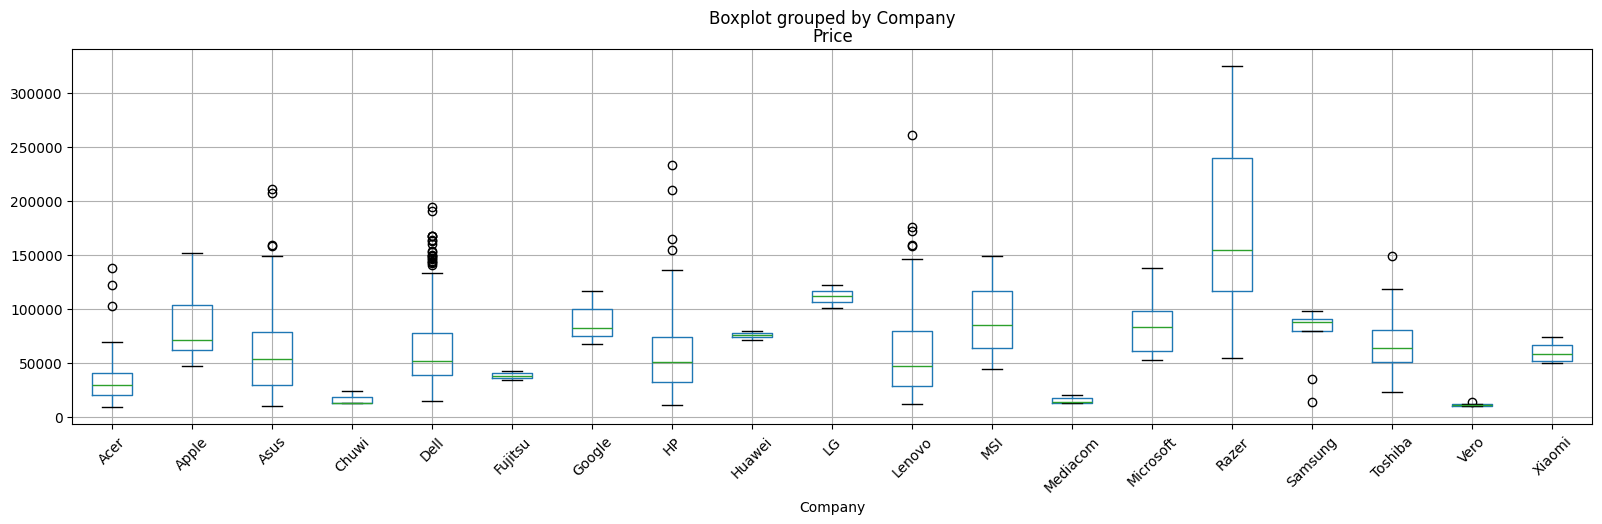

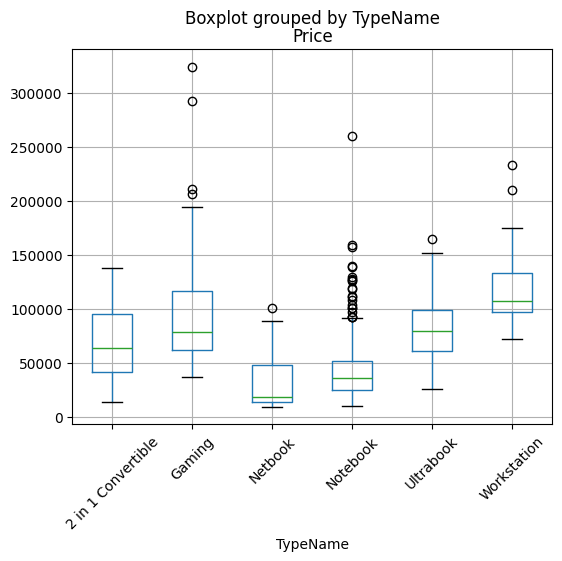

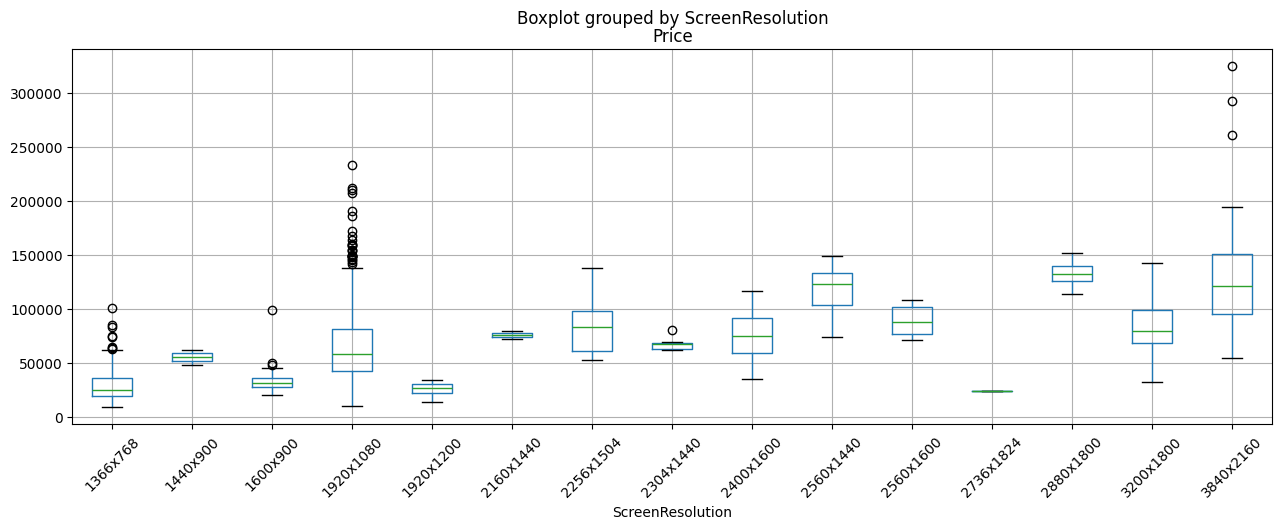

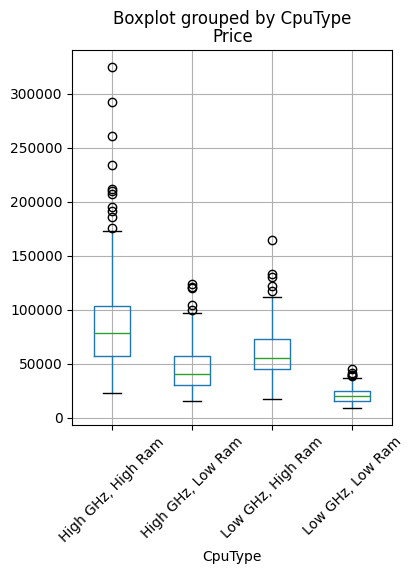

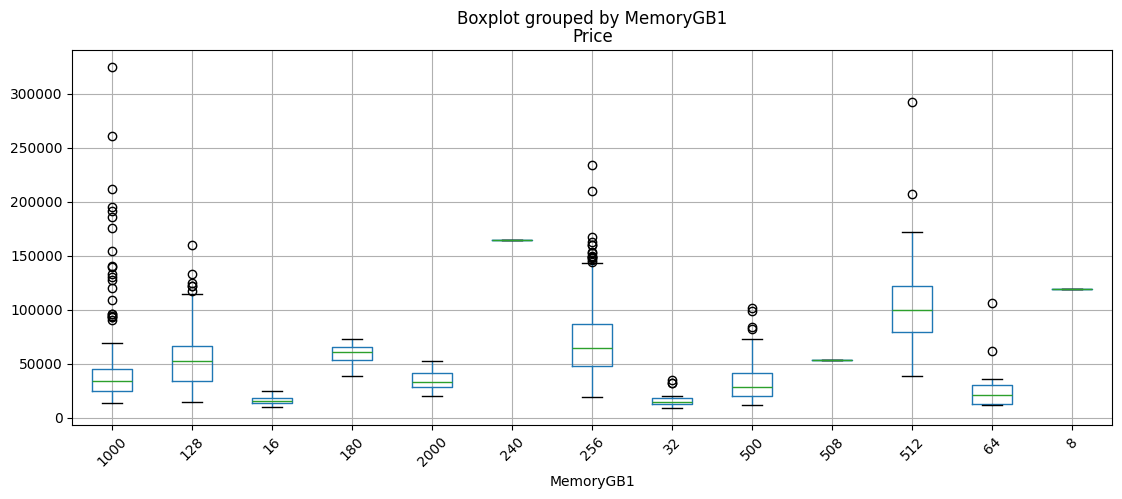

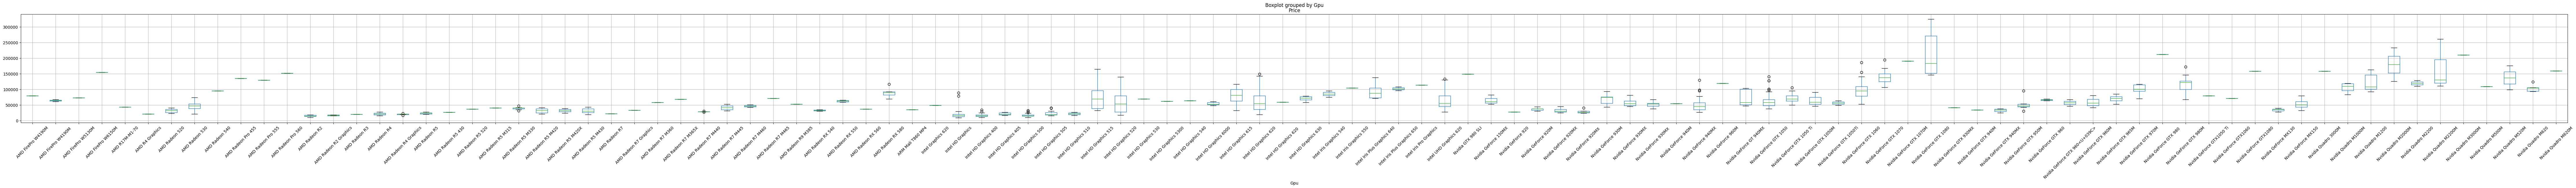

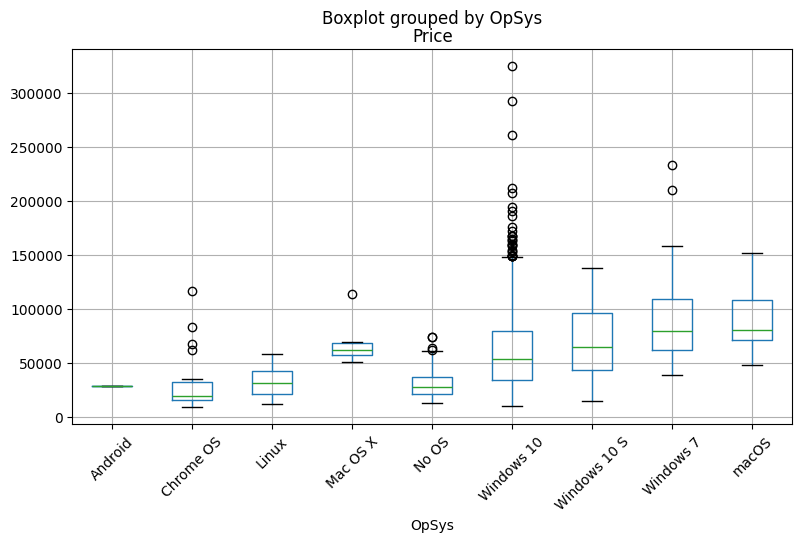

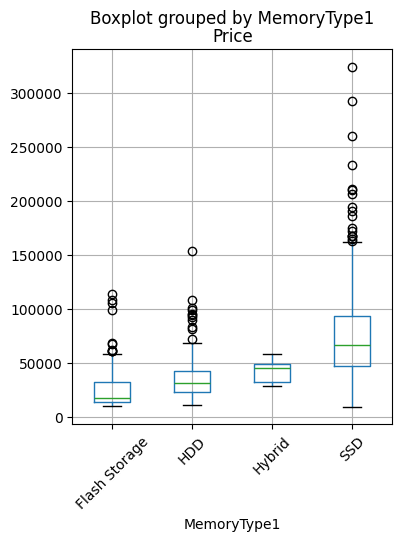

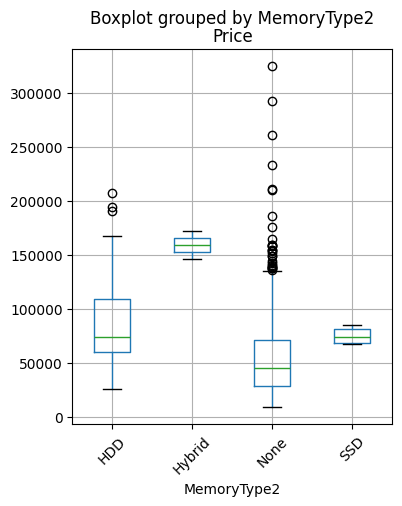

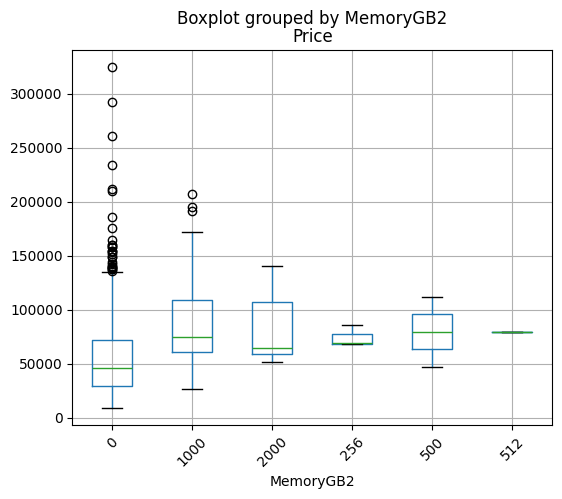

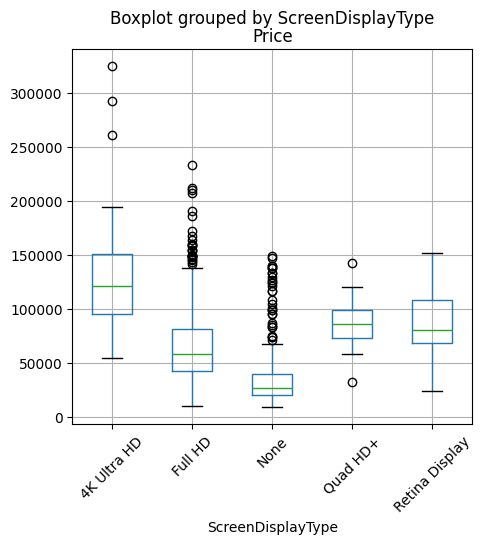

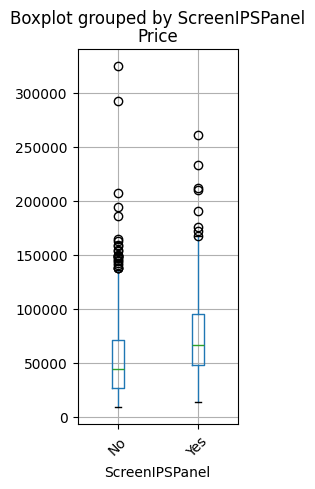

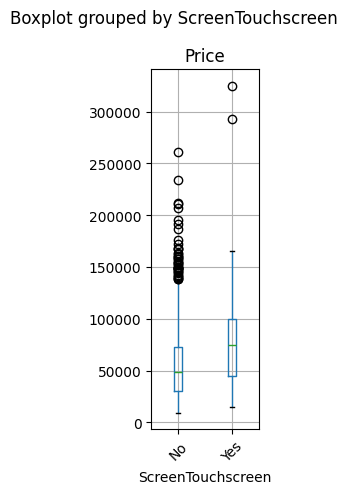

In [ ]:
object_columns = [column for column in Laptop_Data.columns if Laptop_Data[column].dtype == 'object']

for col in object_columns:
  Laptop_Data.boxplot(column = 'Price', by = col, figsize=(Laptop_Data[col].nunique(), 5))
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
Laptop_Data[Laptop_Data['Weight (kg)'] < 0.5]

,Company,TypeName,Inches,ScreenResolution,CpuType,MemoryGB1,Gpu,OpSys,Weight (kg),Price,MemoryType1,MemoryType2,MemoryGB2,ScreenDisplayType,ScreenIPSPanel,ScreenTouchscreen
338,Dell,Ultrabook,15.6,1920x1080,"Low GHz, High Ram",1000,AMD Radeon 530,Windows 10,0.0002,35324.64,HDD,None,0,Full HD,No,No


In [ ]:
Laptop_Data[Laptop_Data['Weight (kg)'] > 7]

,Company,TypeName,Inches,ScreenResolution,CpuType,MemoryGB1,Gpu,OpSys,Weight (kg),Price,MemoryType1,MemoryType2,MemoryGB2,ScreenDisplayType,ScreenIPSPanel,ScreenTouchscreen
128,Acer,Notebook,15.6,1920x1080,"High GHz, Low Ram",256,Nvidia GeForce MX130,Windows 10,7.20,30476.16,SSD,None,0,Full HD,No,No
231,Lenovo,Notebook,15.6,1366x768,"Low GHz, Low Ram",128,Intel HD Graphics 520,Windows 10,7.20,31381.92,SSD,None,0,None,No,No
316,Acer,Notebook,15.6,1366x768,"High GHz, Low Ram",1000,Intel HD Graphics 620,Windows 10,8.23,29250.72,HDD,None,0,None,No,No
572,Lenovo,Ultrabook,14.0,1920x1080,"High GHz, High Ram",256,Intel HD Graphics 520,Windows 10,8.40,89137.44,SSD,None,0,Full HD,Yes,No
612,Asus,Ultrabook,14.0,1920x1080,"High GHz, High Ram",512,Intel HD Graphics 620,Windows 10,11.10,101232.00,SSD,None,0,Full HD,No,No


In [ ]:
Laptop_Data[Laptop_Data['Inches'] > 20]

,Company,TypeName,Inches,ScreenResolution,CpuType,MemoryGB1,Gpu,OpSys,Weight (kg),Price,MemoryType1,MemoryType2,MemoryGB2,ScreenDisplayType,ScreenIPSPanel,ScreenTouchscreen
390,Lenovo,Notebook,25.6,1920x1080,"Low GHz, High Ram",256,AMD Radeon RX 550,Windows 10,2.10,60978.96,SSD,HDD,1000,Full HD,Yes,No
396,Lenovo,Notebook,35.6,1920x1080,"Low GHz, Low Ram",500,Intel HD Graphics 520,Windows 10,2.20,21791.52,HDD,None,0,Full HD,No,No
411,Asus,Notebook,35.6,1920x1080,"High GHz, Low Ram",1000,Nvidia GeForce 940MX,Linux,2.30,31808.16,HDD,None,0,Full HD,No,No
412,Dell,Gaming,27.3,2560x1440,"High GHz, High Ram",256,Nvidia GeForce GTX 1070,Windows 10,4.42,149130.72,SSD,HDD,1000,None,Yes,No
426,Lenovo,Ultrabook,24.0,2560x1440,"High GHz, High Ram",512,Intel HD Graphics 620,Windows 10,1.32,126912.96,SSD,None,0,None,No,No
446,Microsoft,Ultrabook,33.5,2256x1504,"High GHz, High Ram",256,Intel Iris Plus Graphics 640,Windows 10 S,1.25,95850.72,SSD,None,0,None,No,Yes
511,Lenovo,Notebook,24.0,1920x1080,"High GHz, Low Ram",256,Intel HD Graphics 520,Windows 7,2.02,71395.20,SSD,None,0,Full HD,No,No
577,Dell,2 in 1 Convertible,31.6,1366x768,"Low GHz, Low Ram",128,Intel HD Graphics 615,Windows 10,1.39,32127.84,SSD,None,0,None,No,Yes
654,Lenovo,Notebook,35.6,1366x768,"High GHz, Low Ram",128,AMD Radeon R2 Graphics,Windows 10,2.20,18594.72,SSD,None,0,None,No,No


In [ ]:
Laptop_Data = Laptop_Data[(Laptop_Data['Weight (kg)'] > 0.5) & (Laptop_Data['Weight (kg)'] < 7) & (Laptop_Data['Inches'] < 20)]
Laptop_Data["Inches"] = Laptop_Data["Inches"].astype(str)

<ipython-input-196-6afd6b284b99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laptop_Data["Inches"] = Laptop_Data["Inches"].astype(str)


In [ ]:
# Binning

finished = False
while finished == False:
  finished = True
  for column in Laptop_Data.columns:
    if Laptop_Data[column].dtype == 'object':
      for value in Laptop_Data[column].unique():
        if Laptop_Data[column].value_counts()[value] < 20:
          Laptop_Data.loc[:, column] = Laptop_Data.loc[:, column].replace(value, 'Other')
      if 'Other' in Laptop_Data[column].unique() and Laptop_Data[column].value_counts()['Other'] < 20:
        Laptop_Data = Laptop_Data[Laptop_Data.loc[:, column] != 'Other']
        finished = False

In [ ]:
#show_values()

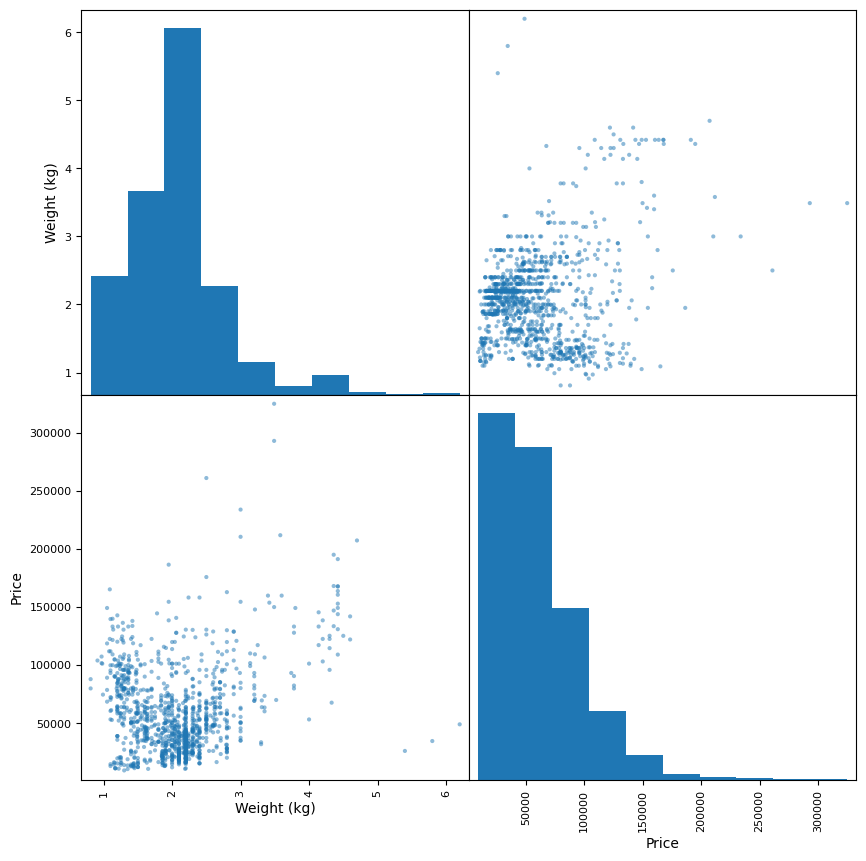

In [ ]:
# Plot Analysis

pd.plotting.scatter_matrix(Laptop_Data, figsize=(10, 10))
plt.show()

In [ ]:
# Reorder columns

Laptop_Data = Laptop_Data.loc[:, ['Company', 'OpSys', 'TypeName', 'Inches', 'Weight (kg)', 'CpuType', 'Gpu',
       'MemoryGB1', 'MemoryType1', 'MemoryGB2', 'MemoryType2',
       'ScreenResolution', 'ScreenDisplayType', 'ScreenIPSPanel', 'ScreenTouchscreen', 'Price']]

In [ ]:
# Encode Categorical Variables

object_columns = [column for column in Laptop_Data.columns if Laptop_Data[column].dtype == 'object']

Laptop_Data = pd.get_dummies(Laptop_Data, columns=object_columns, drop_first=True, dtype=int)
Laptop_Data.head()

,Weight (kg),Price,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Other,Company_Toshiba,OpSys_Linux,...,ScreenResolution_1600x900,ScreenResolution_1920x1080,ScreenResolution_2560x1440,ScreenResolution_3200x1800,ScreenResolution_3840x2160,ScreenDisplayType_Full HD,ScreenDisplayType_None,ScreenDisplayType_Quad HD+,ScreenIPSPanel_Yes,ScreenTouchscreen_Yes
2,1.86,30636.000,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
5,2.10,21312.000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,1.30,79653.600,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
9,1.60,41025.600,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
10,1.86,20986.992,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Check VIF

vif_df = pd.DataFrame()
temp_df = Laptop_Data.drop('Price', axis=1)
temp_df = sm.add_constant(temp_df)

vif_df['Variable'] = temp_df.columns
vif_df['VIF'] = [oi.variance_inflation_factor(temp_df.values, i) for i in range(len(temp_df.columns))]

vif_df.sort_values('VIF', ascending=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
56,ScreenDisplayType_None,inf
57,ScreenDisplayType_Quad HD+,inf
54,ScreenResolution_3840x2160,inf
55,ScreenDisplayType_Full HD,inf
49,MemoryType2_None,inf
48,MemoryGB2_1000,inf
51,ScreenResolution_1920x1080,56.152735
21,Inches_15.6,31.765458
46,MemoryType1_HDD,23.336978
22,Inches_17.3,18.260918


In [ ]:
# Check Correlation Matrix

Laptop_Data.corr()

,Weight (kg),Price,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Other,Company_Toshiba,OpSys_Linux,...,ScreenResolution_1600x900,ScreenResolution_1920x1080,ScreenResolution_2560x1440,ScreenResolution_3200x1800,ScreenResolution_3840x2160,ScreenDisplayType_Full HD,ScreenDisplayType_None,ScreenDisplayType_Quad HD+,ScreenIPSPanel_Yes,ScreenTouchscreen_Yes
Weight (kg),1.000000,0.206838,0.094494,0.072214,-0.125926,-0.036427,0.180077,-0.115919,-0.113298,0.052392,...,0.175913,0.092523,-0.100168,-0.179659,0.058787,0.094093,-0.055839,-0.190945,0.034459,-0.269549
Price,0.206838,1.000000,0.004935,0.061124,-0.020562,-0.026637,0.159629,0.067447,0.043351,-0.163035,...,-0.084001,0.226829,0.203241,0.105929,0.354431,0.233478,-0.423917,0.118773,0.250699,0.201606
Company_Asus,0.094494,0.004935,1.000000,-0.206036,-0.202542,-0.204540,-0.078173,-0.064388,-0.077320,0.019282,...,-0.033278,0.041430,-0.049842,-0.021884,-0.038739,0.036626,-0.014142,-0.026982,-0.069440,-0.066862
Company_Dell,0.072214,0.061124,-0.206036,1.000000,-0.292403,-0.295287,-0.112856,-0.092955,-0.111624,0.190326,...,-0.060557,-0.060098,-0.040569,0.110942,0.122257,-0.059076,-0.018561,0.096187,-0.138575,0.133857
Company_HP,-0.125926,-0.020562,-0.202542,-0.292403,1.000000,-0.290279,-0.110942,-0.091379,-0.109731,-0.123607,...,0.001332,-0.001573,-0.023212,-0.011213,-0.026528,-0.000604,0.017652,-0.019477,-0.075766,-0.062916
Company_Lenovo,-0.036427,-0.026637,-0.204540,-0.295287,-0.290279,1.000000,-0.112036,-0.092280,-0.110813,-0.124825,...,0.120476,0.012924,0.164900,-0.012385,-0.027863,0.018205,-0.014775,0.018732,0.231217,0.029540
Company_MSI,0.180077,0.159629,-0.078173,-0.112856,-0.110942,-0.112036,1.000000,-0.035268,-0.042352,-0.047707,...,-0.028658,0.148390,-0.027301,-0.031209,-0.037411,0.148673,-0.130324,-0.033004,-0.069028,-0.082102
Company_Other,-0.115919,0.067447,-0.064388,-0.092955,-0.091379,-0.092280,-0.035268,1.000000,-0.034884,-0.039295,...,-0.023605,0.034976,-0.022487,-0.025706,0.087192,0.024363,-0.050076,-0.027184,0.045948,0.052906
Company_Toshiba,-0.113298,0.043351,-0.077320,-0.111624,-0.109731,-0.110813,-0.042352,-0.034884,1.000000,-0.047186,...,-0.028345,0.008841,-0.027003,-0.030869,-0.037002,0.009205,0.015952,-0.032644,0.040378,-0.017691
OpSys_Linux,0.052392,-0.163035,0.019282,0.190326,-0.123607,-0.124825,-0.047707,-0.039295,-0.047186,1.000000,...,-0.031930,-0.082210,-0.030417,-0.008274,-0.041681,-0.081743,0.106099,-0.011648,-0.132778,-0.080076


In [ ]:
# Check Correlated Values

corr_matrix = Laptop_Data.corr()
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i, j]) > 0.7:
      print(f'{corr_matrix.columns[i]} and {corr_matrix.columns[j]}')

MemoryType1_SSD and MemoryType1_HDD
MemoryType2_None and MemoryGB2_1000
ScreenDisplayType_Full HD and ScreenResolution_1920x1080
ScreenDisplayType_None and ScreenResolution_1920x1080
ScreenDisplayType_None and ScreenDisplayType_Full HD
ScreenDisplayType_Quad HD+ and ScreenResolution_3200x1800


In [ ]:
# Save to csv
Laptop_Data.to_csv('/content/drive/MyDrive/Personal Files/Regression Practice/Laptop_Data_Cleaned.csv', index=False)